In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

c:\Users\divy2\Desktop\Dominoes\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
merged_data = pd.read_csv("merged_dominos_data.csv")
merged_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187366,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,60.0,3,12,53,2015,0,0
187367,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,100.0,3,12,53,2015,0,0
187368,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,20.0,3,12,53,2015,0,0
187369,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,5.0,3,12,53,2015,0,0


TRAIN-TEST SPLIT

In [3]:
# Preparing the Data for Time Series Forecasting
#  Converting order_date to datetime format
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

merged_data = merged_data.set_index('order_date').sort_index()

daily_sales = merged_data['total_price'].resample('D').sum()

print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187371, 18)


In [4]:
merged_data.head(10)

,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
order_date,,,,,,,,,,,,,,,,,,
2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
2015-01-01,2,2,classic_dlx_m,1,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
2015-01-01,2,2,classic_dlx_m,1,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0
2015-01-01,2,2,classic_dlx_m,1,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,100.0,3,1,1,2015,1,0
2015-01-01,3,2,five_cheese_l,1,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,30.0,3,1,1,2015,1,0
2015-01-01,3,2,five_cheese_l,1,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,15.0,3,1,1,2015,1,0
2015-01-01,4,2,ital_supr_l,1,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,150.0,3,1,1,2015,1,0


In [5]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 252 pizzas
The Big Meat Pizza: 99 pizzas
The Brie Carre Pizza: 48 pizzas
The Calabrese Pizza: 72 pizzas
The California Chicken Pizza: 212 pizzas
The Chicken Alfredo Pizza: 92 pizzas
The Chicken Pesto Pizza: 76 pizzas
The Classic Deluxe Pizza: 117 pizzas
The Five Cheese Pizza: 60 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 155 pizzas
The Green Garden Pizza: 105 pizzas
The Hawaiian Pizza: 135 pizzas
The Italian Capocollo Pizza: 108 pizzas
The Italian Supreme Pizza: 144 pizzas
The Italian Vegetables Pizza: 103 pizzas
The Mediterranean Pizza: 53 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 112 pizzas
The Pepper Salami Pizza: 85 pizzas
The Pepperoni Pizza: 110 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 39 pizzas
The Prosciutto and Arugula Pizza: 65 pizzas
The Sicilian Pizza: 212 pizzas
The Soppressata Pizza: 76 pizzas
The Southwest Chicken Pizza: 205 pizzas
The Spicy Italian Pizza: 159 pizzas
The Spinach

EXPLORATORY DATA ANALYSIS

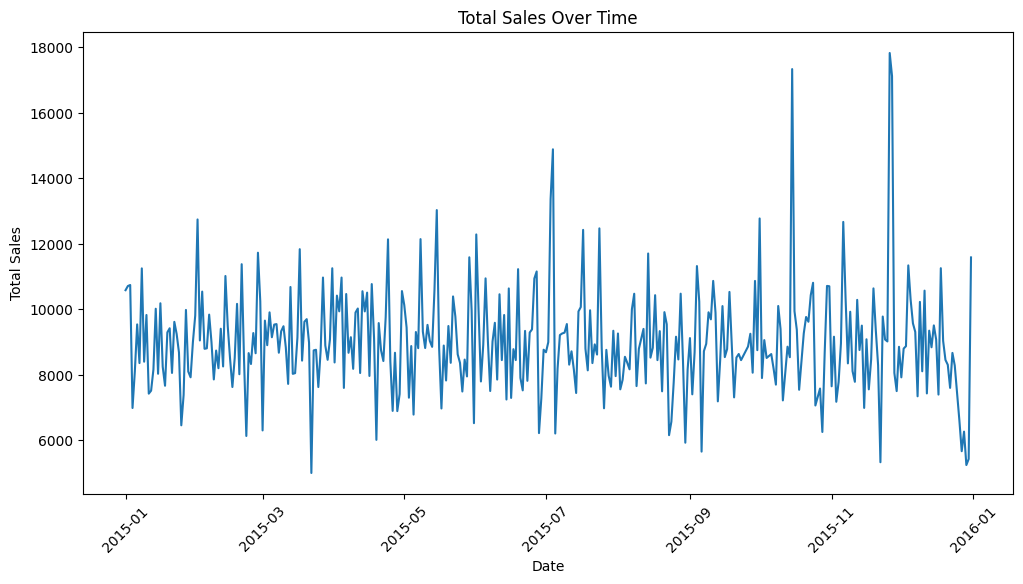

In [6]:
#Analyzing Sales Trends Over Time

# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

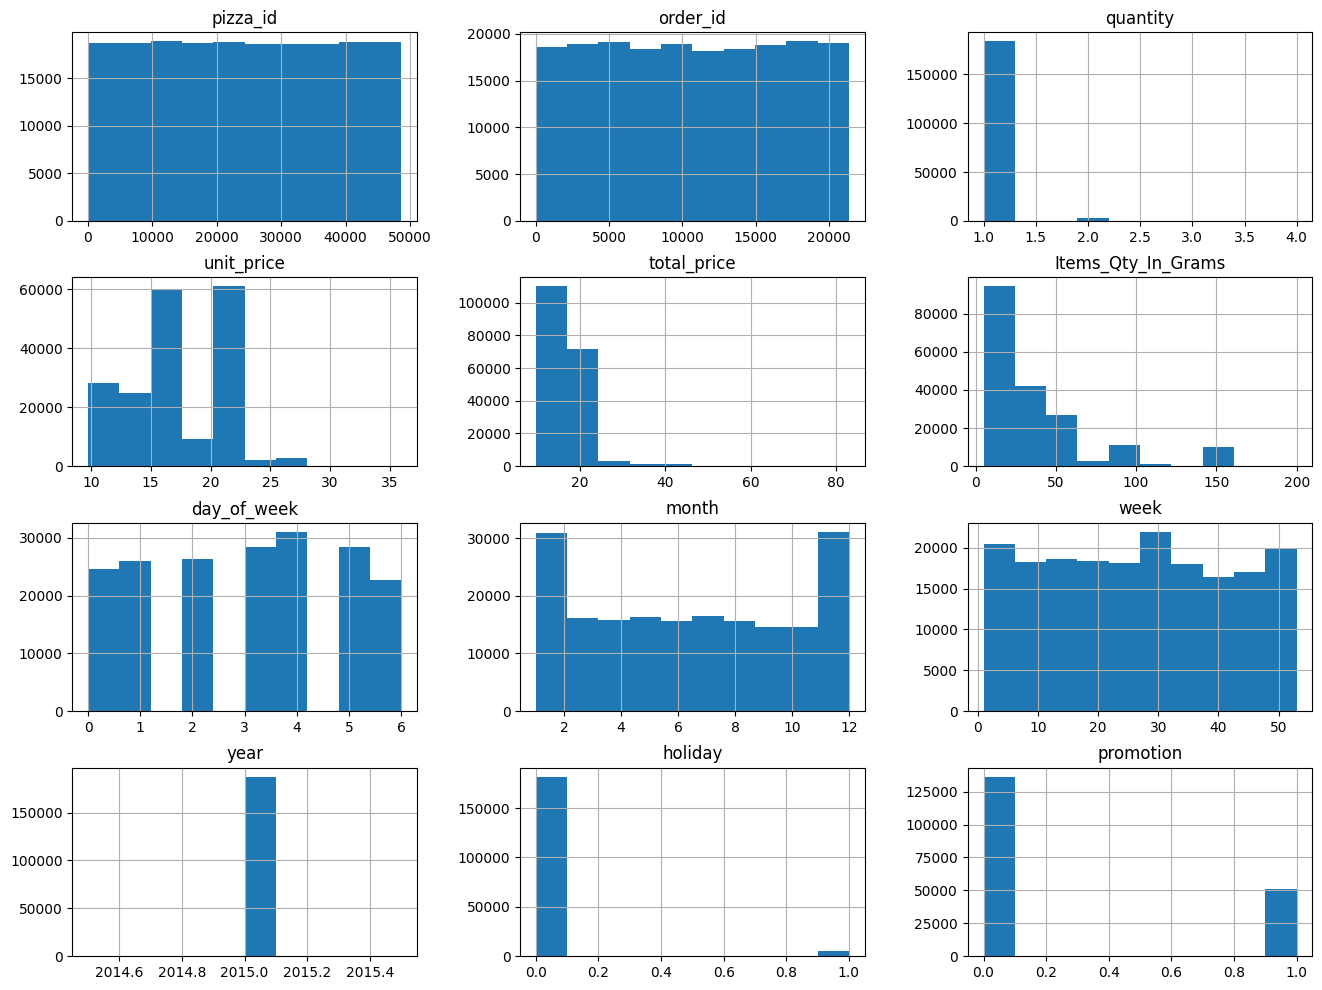

In [7]:
merged_data.hist(figsize=(16,12))
plt.show()

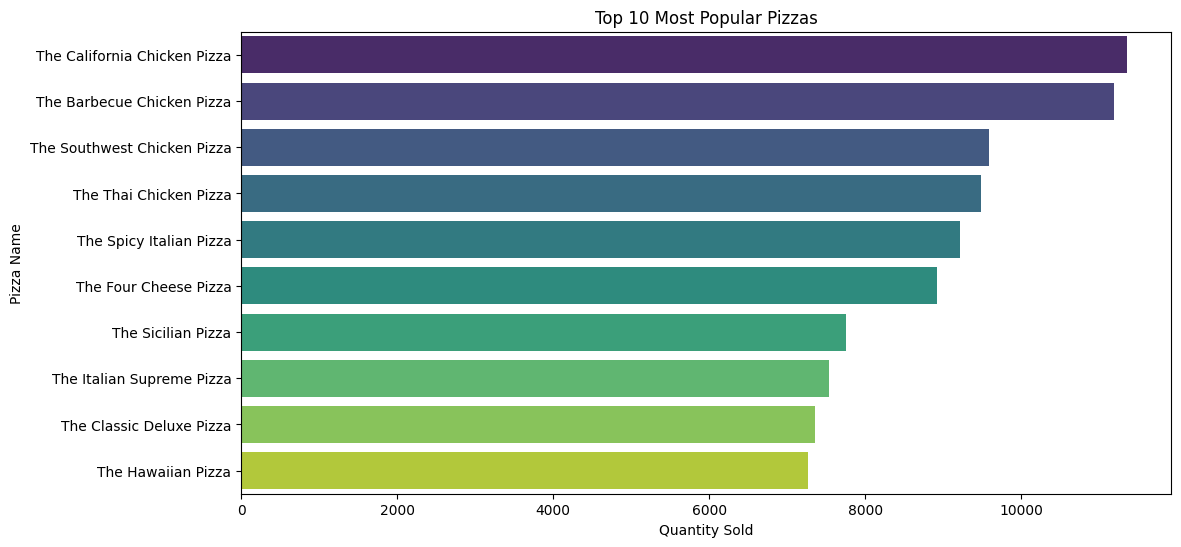

In [8]:
#TOP SELLLING PIZZA

# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

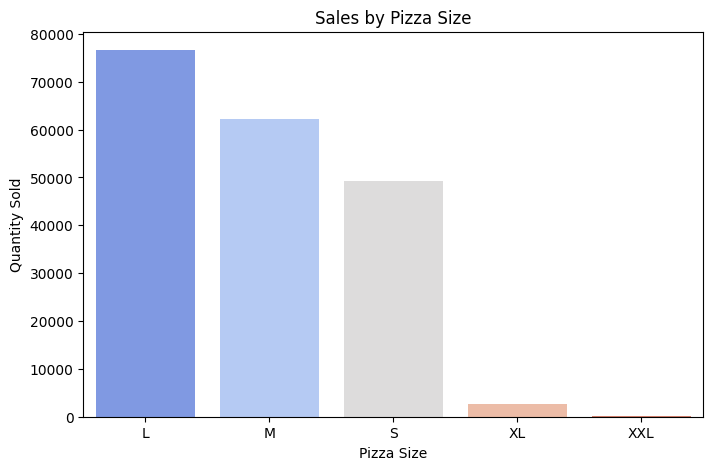

In [9]:
# SALES BY PIZZA SIZE AND CATEGORY
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

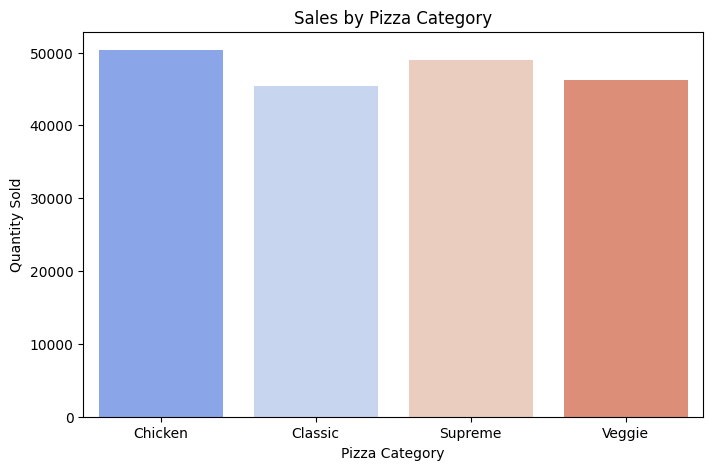

In [10]:
# SALES BY PIZZA CATEGORY AND QUANTITY

# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

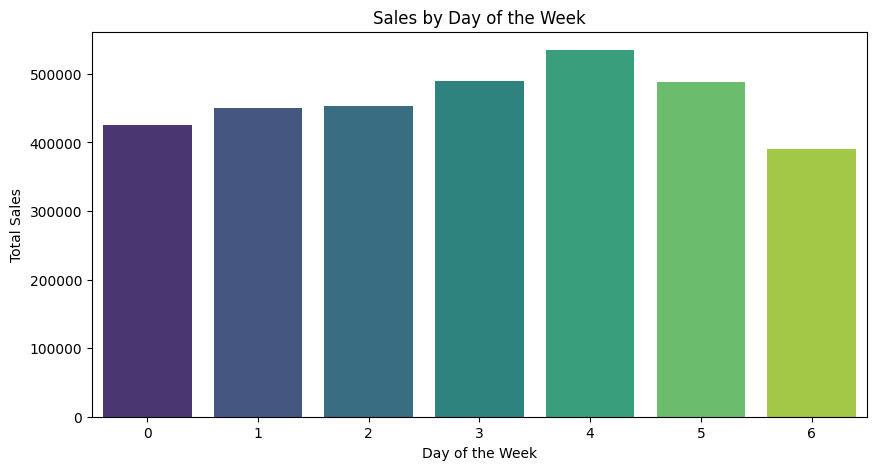

In [11]:
#SEASONAL SALES TRENDS AND PATTERNS

# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

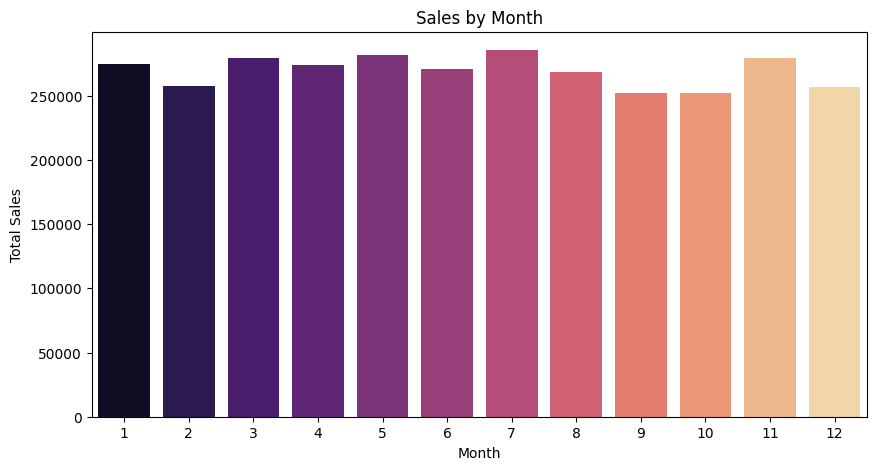

In [12]:
#SALES BY MONTH

# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

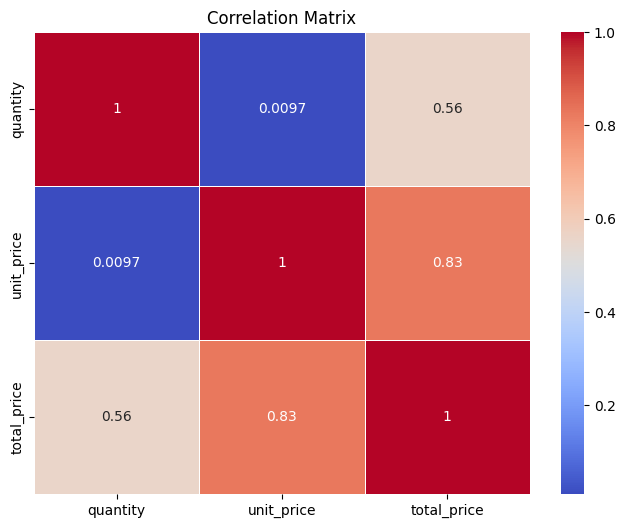

In [13]:
#CORRELATION ANALYSIS OF SALES METRICS

# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


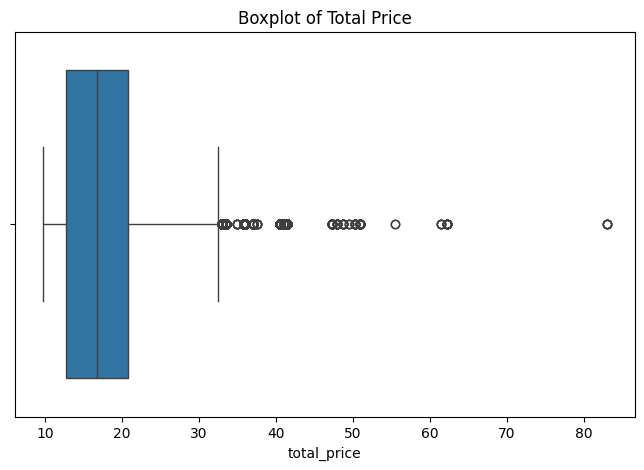

In [14]:
#OUTLIER DETECTION IN SALES DATA
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()


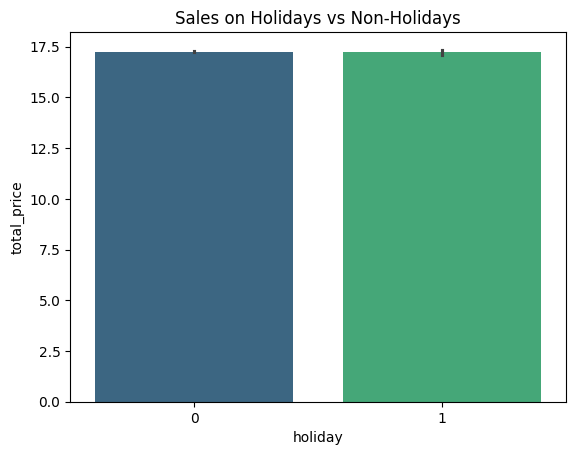

In [15]:
#SALES DURING HOLIDAYS VS NON HOLIDAYS
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

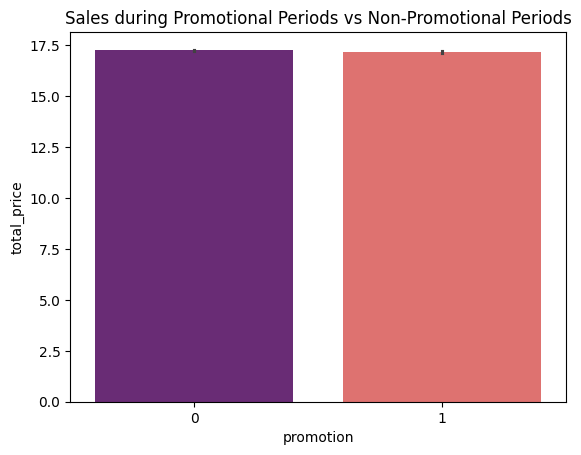

In [16]:
#SALES DURING PROPMOTIONS VS NON PROMOTIONS
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

MODEL BUILDING

1- ARIMA MODEL

Best ARIMA Model MAPE: 0.1900, Best Parameters: (2, 0, 2)
Predictions:
order_date
2015-10-19    3372.424222
2015-10-26    3552.933248
2015-11-02    3682.610234
2015-11-09    3717.158752
2015-11-16    3687.498137
2015-11-23    3643.470072
2015-11-30    3616.674449
2015-12-07    3612.740979
2015-12-14    3621.849361
2015-12-21    3632.189589
2015-12-28    3637.462097
Name: predicted_mean, dtype: float64


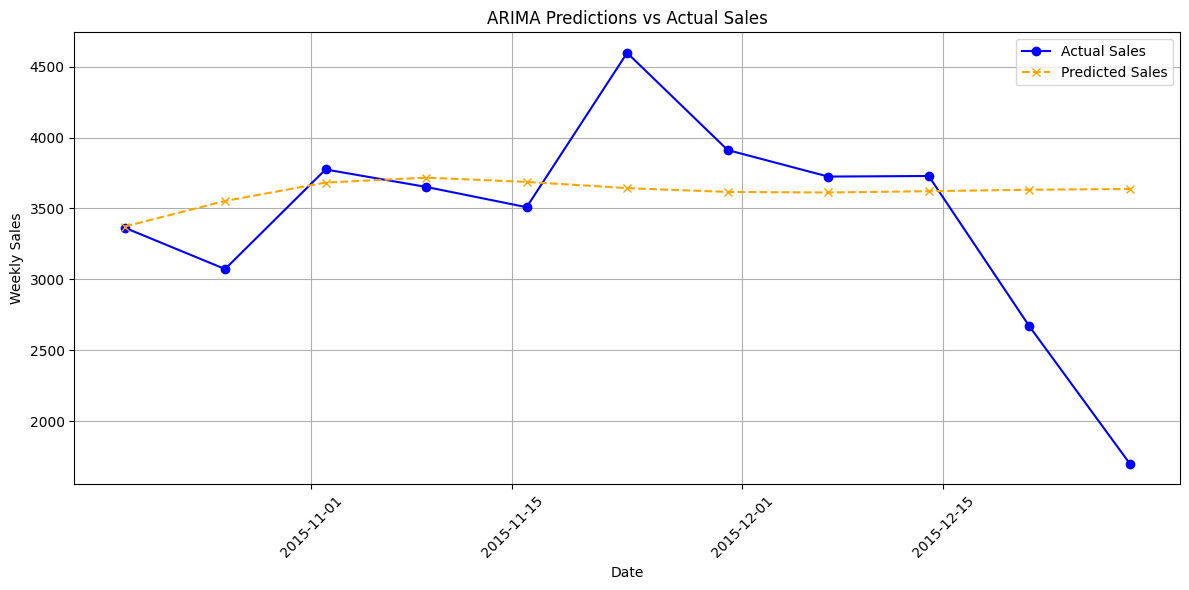

In [17]:
# Load your dataset (replace 'your_file.csv' with the actual filename)
pizza_sales = pd.read_csv("merged_dominos_data.csv")

# Ensure 'order_date' column exists and is in datetime format
if 'order_date' not in pizza_sales.columns:
    raise KeyError("'order_date' column is missing from the dataset.")

pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'], errors='coerce')

# Drop rows where 'order_date' or 'quantity' is invalid
pizza_sales = pizza_sales.dropna(subset=['order_date', 'quantity'])

# Ensure 'quantity' is numeric
pizza_sales['quantity'] = pd.to_numeric(pizza_sales['quantity'], errors='coerce')
pizza_sales = pizza_sales.dropna(subset=['quantity'])

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


2-SARIMA

Best SARIMA Model MAPE: 0.1849
Predictions:
order_date
2015-10-19    3251.160979
2015-10-26    3647.425227
2015-11-02    3407.607722
2015-11-09    2750.328266
2015-11-16    3590.419609
2015-11-23    3085.020012
2015-11-30    3327.511951
2015-12-07    3156.056388
2015-12-14    3475.833966
2015-12-21    3266.423052
2015-12-28    2593.256148
Name: predicted_mean, dtype: float64


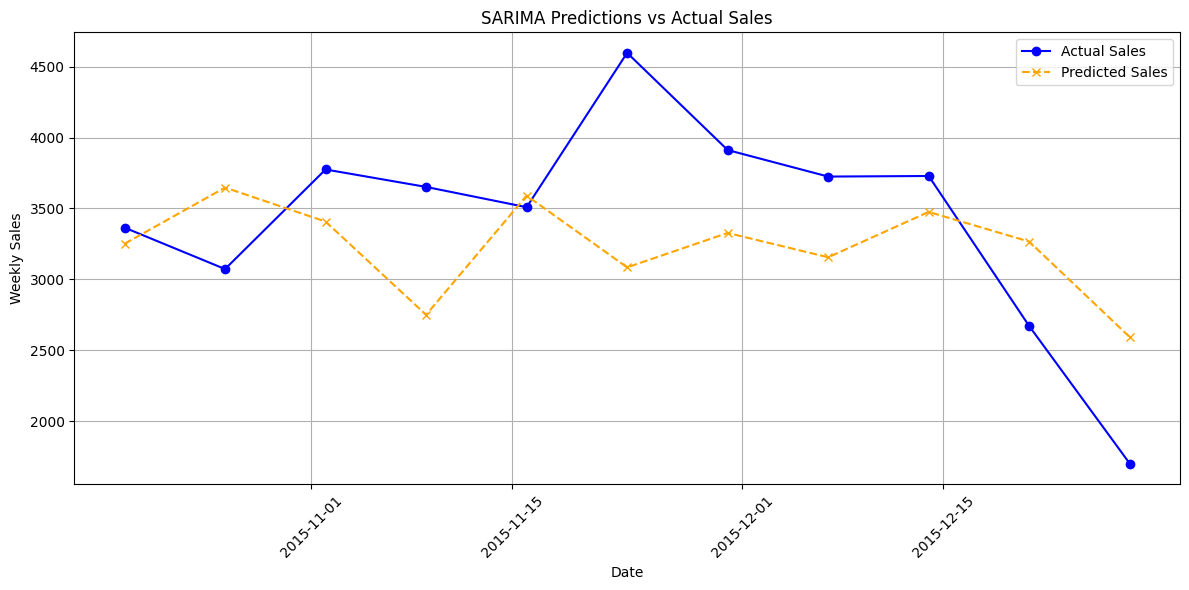

In [18]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


3-PROPHET

13:32:51 - cmdstanpy - INFO - Chain [1] start processing
13:32:51 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.1962
Predictions:
ds
2015-10-19    3619.974537
2015-10-26    3618.552805
2015-11-02    3617.131073
2015-11-09    3615.709341
2015-11-16    3614.287609
2015-11-23    3612.865877
2015-11-30    3611.444145
2015-12-07    3610.022413
2015-12-14    3608.600681
2015-12-21    3607.178949
2015-12-28    3605.757217
dtype: float64


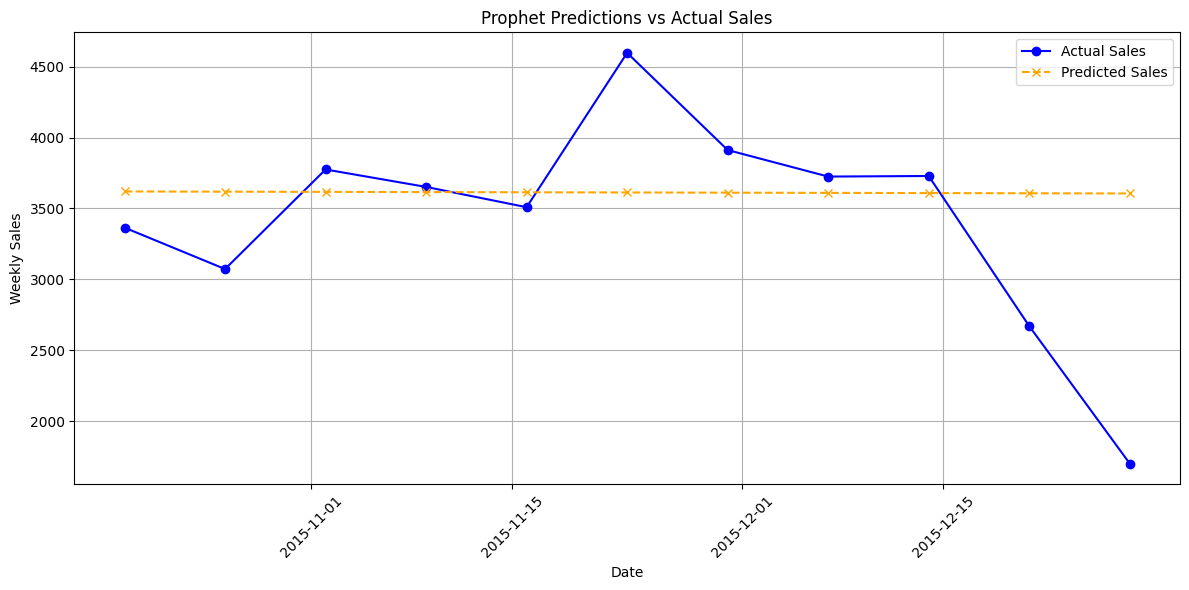

In [19]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

4-LSTM

1/1 [==============================] - 0s 193ms/step
Best LSTM Model MAPE: 0.2376
Predictions:
order_date
2015-11-09    3497.682129
2015-11-16    3554.267090
2015-11-23    3685.413818
2015-11-30    3836.756348
2015-12-07    3927.337891
2015-12-14    4043.863037
2015-12-21    3786.575195
2015-12-28    3526.111572
dtype: float32


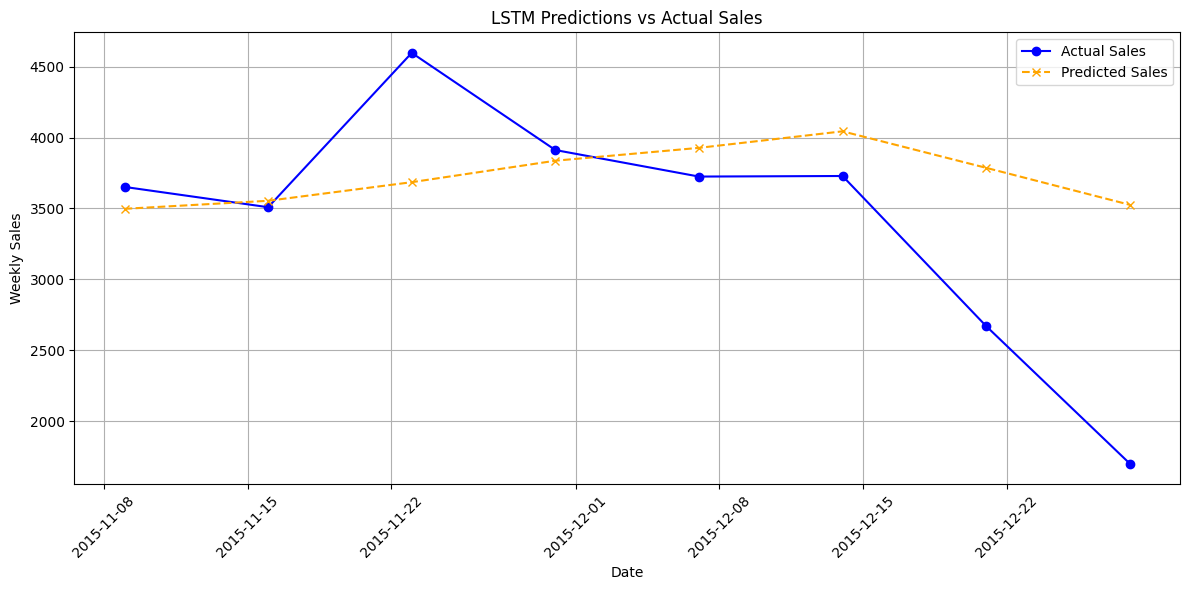

In [20]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

5-REGRESSION 

Best Regression Model MAPE: 0.1911
Predictions:
order_date
2015-10-19    3545.287304
2015-10-26    3530.562085
2015-11-02    3552.361183
2015-11-09    3537.635964
2015-11-16    3522.910745
2015-11-23    3508.185526
2015-11-30    3493.460307
2015-12-07    3515.259404
2015-12-14    3500.534185
2015-12-21    3485.808966
2015-12-28    3471.083747
dtype: float64


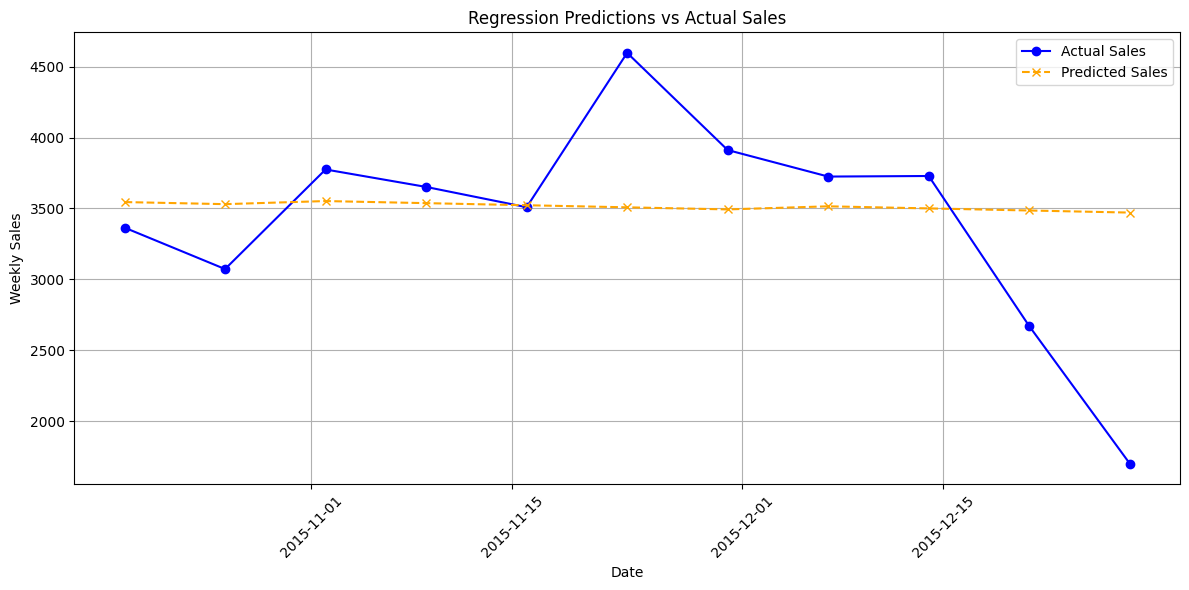

In [21]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    
    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

FORECASTED SALES FOR THE WEEK

1-ARIMA MODEL FORECASTED SALES FOR THE WEEK

In [22]:
# ARIMA Model forecasted sales for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 92 pizzas
bbq_ckn_m: 86 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 37 pizzas
calabrese_m: 43 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 81 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 14 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 9 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 21 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 46 pizzas
five_cheese_l: 56 pizzas
four_cheese_l: 114 pizzas
four_cheese_m: 45 pizzas
green_garden_l: 10 pizzas
green_garden_m: 25 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 50 pizzas
hawaiian_m: 24 pizzas
hawaiian_s: 52 pizzas
ital_cpcllo_l: 55 pizzas
ital_cpcllo_m: 30 pizzas
ital_cpcllo_s: 23 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 66 pizzas
ital_supr_s: 14 pizzas
ital_veggie_l: 20 pizzas
ital_veggie_m: 36 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 36 pizzas
mediterraneo_m: 23 pizzas
mediterraneo_s

2-SARIMA MODEL FORECASTED SALES FOR THE WEEK

In [23]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 83 pizzas
bbq_ckn_m: 94 pizzas
bbq_ckn_s: 39 pizzas
big_meat_s: 89 pizzas
brie_carre_s: 56 pizzas
calabrese_m: 40 pizzas
calabrese_s: 6 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 56 pizzas
cali_ckn_s: 37 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 58 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 14 pizzas
classic_dlx_l: 19 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 39 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 149 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 2 pizzas
green_garden_m: 28 pizzas
green_garden_s: 47 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 20 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 60 pizzas
ital_cpcllo_m: 37 pizzas
ital_cpcllo_s: 26 pizzas
ital_supr_l: 62 pizzas
ital_supr_m: 49 pizzas
ital_supr_s: 3 pizzas
ital_veggie_l: 16 pizzas
ital_veggie_m: 25 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 29 pizzas
mediterraneo_s: 1

3-PROPHET MODEL FORECASTED SALES FOR THE WEEK


In [24]:
# Function to forecast sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})
    
    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)
    
    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

13:35:13 - cmdstanpy - INFO - Chain [1] start processing
13:35:13 - cmdstanpy - INFO - Chain [1] done processing
13:35:14 - cmdstanpy - INFO - Chain [1] start processing
13:35:14 - cmdstanpy - INFO - Chain [1] done processing
13:35:14 - cmdstanpy - INFO - Chain [1] start processing
13:35:14 - cmdstanpy - INFO - Chain [1] done processing
13:35:14 - cmdstanpy - INFO - Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing
13:35:15 - cmdstanpy - INFO - Chain [1] start processing
13:35:15 - cmdstanpy - INFO - Chain [1] done processing
13:35:15 - cmdstanpy - INFO - Chain [1] start processing
13:35:16 - cmdstanpy - INFO - Chain [1] done processing
13:35:16 - cmdstanpy - INFO - Chain [1] start processing
13:35:16 - cmdstanpy - INFO - Chain [1] done processing
13:35:16 - cmdstanpy - INFO - Chain [1] start processing
13:35:17 - cmdstanpy - INFO - Chain [1] done processing
13:35:17 - cmdstanpy - INFO - Chain [1] start processing
13:35:18 - cmdstanpy - INFO - Chain [1]

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 605 pizzas
bbq_ckn_m: 660 pizzas
bbq_ckn_s: 187 pizzas
big_meat_s: 766 pizzas
brie_carre_s: 275 pizzas
calabrese_m: 309 pizzas
calabrese_s: 55 pizzas
cali_ckn_l: 604 pizzas
cali_ckn_m: 563 pizzas
cali_ckn_s: 281 pizzas
ckn_alfredo_l: 111 pizzas
ckn_alfredo_m: 450 pizzas
ckn_alfredo_s: 70 pizzas
ckn_pesto_l: 218 pizzas
ckn_pesto_m: 165 pizzas
ckn_pesto_s: 149 pizzas
classic_dlx_l: 185 pizzas
classic_dlx_m: 520 pizzas
classic_dlx_s: 323 pizzas
five_cheese_l: 379 pizzas
four_cheese_l: 862 pizzas
four_cheese_m: 304 pizzas
green_garden_l: 77 pizzas
green_garden_m: 167 pizzas
green_garden_s: 361 pizzas
hawaiian_l: 385 pizzas
hawaiian_m: 208 pizzas
hawaiian_s: 366 pizzas
ital_cpcllo_l: 417 pizzas
ital_cpcllo_m: 180 pizzas
ital_cpcllo_s: 153 pizzas
ital_supr_l: 389 pizzas
ital_supr_m: 473 pizzas
ital_supr_s: 106 pizzas
ital_veggie_l: 94 pizzas
ital_veggie_m: 239 pizzas
ital_veggie_s: 98 pizzas
mediterraneo_l: 255 pizzas
mediter

MODEL EVALUATION

In [25]:
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression', 'LSTM'],
    'MAPE': [0.1902, 0.1849, 0.1962, 0.1911, 0.2354],
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
1,SARIMA,0.1849,1.0,Best
0,ARIMA,0.1902,2.0,
3,Regression,0.1911,3.0,
2,Prophet,0.1962,4.0,
4,LSTM,0.2354,5.0,Worst


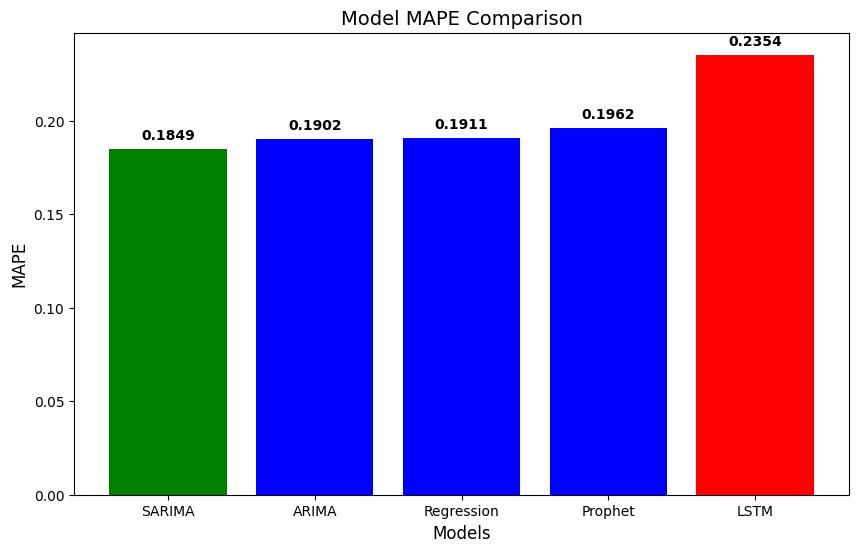

In [26]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1849, 0.1902, 0.1911, 0.1962, 0.2354]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()


SARIMA IS THE BEST AS IT HAS THE LOWEST MAPE VALUE

In [27]:
train

,order_date,quantity,week_of_year,day_of_week,month,year
0,2014-12-29,2282,1,0,12,2014
1,2015-01-05,3735,2,0,1,2015
2,2015-01-12,3528,3,0,1,2015
3,2015-01-19,3674,4,0,1,2015
4,2015-01-26,3778,5,0,1,2015
5,2015-02-02,3802,6,0,2,2015
6,2015-02-09,3760,7,0,2,2015
7,2015-02-16,3574,8,0,2,2015
8,2015-02-23,3750,9,0,2,2015
9,2015-03-02,3822,10,0,3,2015


In [28]:
# SARIMA model
sarima_model = SARIMAX(train['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -249.207
Date:                           Wed, 18 Dec 2024   AIC                            508.415
Time:                                   13:36:11   BIC                            516.047
Sample:                                        0   HQIC                           511.017
                                            - 42                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3903      0.258     -1.515      0.130      -0.895       0.115
ma.L1         -0.4659      0.256     -1.821

In [29]:
#HYPERPARAMETER TUNING FOR SARIMA

# Useing auto_arima to find the best parameters
auto_model = auto_arima(train['quantity'], seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=511.712, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=514.320, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=505.463, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=505.981, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=505.755, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=506.874, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=507.029, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=505.031, Time=0.08 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=507.029, Time=0.33 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=515.392, Time=0.07 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=506.899, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=506.415, Time=0.13 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=508.051, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=505.414, 

In [30]:
#saving the model using pickle
import pickle # Importing pickle for saving the model

# Save the model to a file using pickle
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_sarima_model.pkl


In [31]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.


FINAL PREDICTIONS

In [86]:
test.head()

,order_date,quantity,week_of_year,day_of_week,month,year
42,2015-10-19,3365,43,0,10,2015
43,2015-10-26,3073,44,0,10,2015
44,2015-11-02,3775,45,0,11,2015
45,2015-11-09,3652,46,0,11,2015
46,2015-11-16,3509,47,0,11,2015


In [38]:
import pickle
import pandas as pd
import numpy as np

# Debugging function to load and verify the model
def load_and_verify_model(model_filename):
    try:
        with open(model_filename, 'rb') as file:
            loaded_model = pickle.load(file)
        
        # Print model type and available methods
        print("Model Type:", type(loaded_model))
        print("Available methods:", dir(loaded_model))
        
        return loaded_model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Alternative forecasting function with error handling
def forecast_sales(loaded_model, periods, start_date=None):
    try:
        # Check if the model has a predict method
        if not hasattr(loaded_model, 'predict'):
            print("Warning: Model does not have a predict method")
            return None
        
        # Try different prediction approaches
        try:
            # First, try direct prediction
            forecast = loaded_model.predict(n_periods=periods)
        except TypeError:
            try:
                # Try without specifying n_periods
                forecast = loaded_model.predict(steps=periods)
            except Exception as e:
                print(f"Prediction error: {e}")
                return None
        
        # Ensure forecast is a numpy array or list
        forecast = np.array(forecast)
        
        # Generate date index
        if start_date is None:
            start_date = pd.Timestamp.today().floor('D')
        
        date_index = pd.date_range(start=start_date, periods=periods, freq='W-MON')
        
        # Create Series with actual values
        forecast_series = pd.Series(forecast, index=date_index)
        
        return forecast_series
    
    except Exception as e:
        print(f"Unexpected error in forecast_sales: {e}")
        return None

# Main execution
model_filename = 'best_sarima_model.pkl'
loaded_model = load_and_verify_model(model_filename)

if loaded_model:
    start_date = pd.Timestamp('2015-10-19')
    forecasted_sales = forecast_sales(loaded_model, periods=7, start_date=start_date)
    
    if forecasted_sales is not None:
        print("\nForecasted Sales:")
        print(forecasted_sales)
    else:
        print("Failed to generate forecast")

Model Type: <class 'pmdarima.arima.arima.ARIMA'>
Available methods: ['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_exog', '_check_feature_names', '_check_n_features', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_fit', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', '_validate_params', '_warn_for_older_version', 'aic', 'aicc', 'arima_res_', 'arparams', 'arroots', 'bic', 'bse', 'c

In [110]:
train.index[-1]

41

In [87]:
train

,order_date,quantity,week_of_year,day_of_week,month,year
0,2014-12-29,2282,1,0,12,2014
1,2015-01-05,3735,2,0,1,2015
2,2015-01-12,3528,3,0,1,2015
3,2015-01-19,3674,4,0,1,2015
4,2015-01-26,3778,5,0,1,2015
5,2015-02-02,3802,6,0,2,2015
6,2015-02-09,3760,7,0,2,2015
7,2015-02-16,3574,8,0,2,2015
8,2015-02-23,3750,9,0,2,2015
9,2015-03-02,3822,10,0,3,2015


In [50]:
train.reset_index(drop=True, inplace=True)


In [32]:
Ingredients_dataset = pd.read_csv("Ingredients_dataset.csv")
# Displaying the total quantity of predicted ingredients

# Displaying the total quantity of predicted ingredients

# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2540.0, 'Alfredo Sauce': 1285.0, 'Anchovies': 3295.0, 'Artichokes': 10535.0, 'Arugula': 705.0, 'Asiago Cheese': 6200.0, 'Bacon': 28670.0, 'Barbecue Sauce': 2375.0, 'Barbecued Chicken': 6800.0, 'Beef Chuck Roast': 10660.0, 'Blue Cheese': 1680.0, 'Brie Carre Cheese': 1110.0, 'Calabrese Salami': 15100.0, 'Capocollo': 62100.0, 'Caramelized Onions': 592.0, 'Chicken': 81150.0, 'Chipotle Sauce': 7330.0, 'Chorizo Sausage': 5350.0, 'Cilantro': 3665.0, 'Coarse Sicilian Salami': 11480.0, 'Corn': 24540.0, 'Eggplant': 2960.0, 'Feta Cheese': 9970.0, 'Fontina Cheese': 5920.0, 'Friggitello Peppers': 635.0, 'Garlic': 23875.0, 'Genoa Salami': 8790.0, 'Goat Cheese': 12940.0, 'Gorgonzola Piccante Cheese': 5460.0, 'Gouda Cheese': 4490.0, 'Green Olives': 4745.0, 'Green Peppers': 6765.0, 'Italian Sausage': 1070.0, 'Jalapeno Peppers': 5910.0, 'Kalamata Olives': 3070.0, 'Luganega Sausage': 5740.0, 'Mozzarella Cheese': 11560.0, 'Mu

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,92,3680.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,92,1380.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,92,1840.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,92,2760.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,92,5520.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,33,660.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,33,660.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,33,330.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,33,495.0


In [33]:
ingredient_totals

{'?duja Salami': 2540.0,
 'Alfredo Sauce': 1285.0,
 'Anchovies': 3295.0,
 'Artichokes': 10535.0,
 'Arugula': 705.0,
 'Asiago Cheese': 6200.0,
 'Bacon': 28670.0,
 'Barbecue Sauce': 2375.0,
 'Barbecued Chicken': 6800.0,
 'Beef Chuck Roast': 10660.0,
 'Blue Cheese': 1680.0,
 'Brie Carre Cheese': 1110.0,
 'Calabrese Salami': 15100.0,
 'Capocollo': 62100.0,
 'Caramelized Onions': 592.0,
 'Chicken': 81150.0,
 'Chipotle Sauce': 7330.0,
 'Chorizo Sausage': 5350.0,
 'Cilantro': 3665.0,
 'Coarse Sicilian Salami': 11480.0,
 'Corn': 24540.0,
 'Eggplant': 2960.0,
 'Feta Cheese': 9970.0,
 'Fontina Cheese': 5920.0,
 'Friggitello Peppers': 635.0,
 'Garlic': 23875.0,
 'Genoa Salami': 8790.0,
 'Goat Cheese': 12940.0,
 'Gorgonzola Piccante Cheese': 5460.0,
 'Gouda Cheese': 4490.0,
 'Green Olives': 4745.0,
 'Green Peppers': 6765.0,
 'Italian Sausage': 1070.0,
 'Jalapeno Peppers': 5910.0,
 'Kalamata Olives': 3070.0,
 'Luganega Sausage': 5740.0,
 'Mozzarella Cheese': 11560.0,
 'Mushrooms': 25860.0,
 'Onions

In [36]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


<Figure size 2500x1500 with 0 Axes>

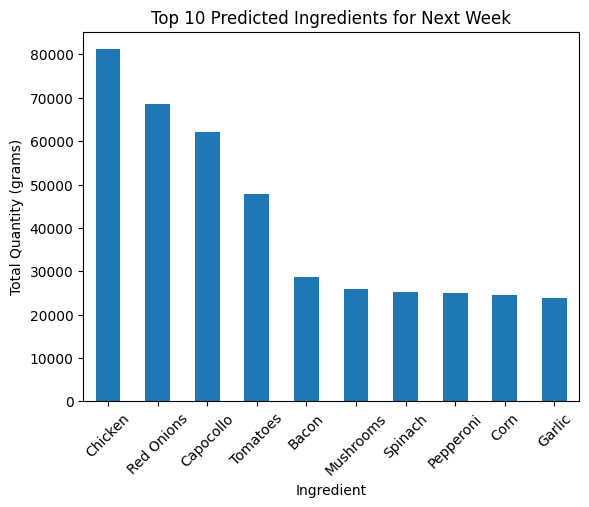

In [37]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(25, 15))
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(kind='bar', x='Ingredient', y='Total Quantity (grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()

In [38]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2540.0
1,Alfredo Sauce,1285.0
2,Anchovies,3295.0
3,Artichokes,10535.0
4,Arugula,705.0
...,...,...
59,Sun-dried Tomatoes,1490.0
60,Thai Sweet Chilli Sauce,4160.0
61,Thyme,185.0
62,Tomatoes,47730.0
